# Interactive runner of SAYNT project

This interactive runner should be used for running (S)PAYNT, reinforcement learning sub-project and figure plotter.

Import TensorFlow and PAYNT related stuff.

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tf_agents
import sys


## Run reinforcement learning

Example of how to run reinforcement learning project with custom arguments.

In [52]:
sys.path.append("rl_src")
from rl_src.experiment_runner import run_single_experiment
from rl_src.tools.args_emulator import ArgsEmulator

In [53]:
name_of_experiment = "test_jupyter" # Name of the experiment, there will be stored experiment results.

prism_model = "rl_src/models/evade/sketch.templ"
prism_properties = "rl_src/models/evade/sketch.props"

learning_rate = 0.00016
batch_size = 256
num_environments = batch_size
randomized_starts = False

learning_method = "Stochastic_PPO"
agent_name = "evade"

run_rl = False

In [54]:

args = ArgsEmulator(
    prism_model=prism_model, prism_properties=prism_properties, learning_rate=learning_rate,
    restart_weights=0, learning_method=learning_method, evaluation_episodes=30,
    nr_runs=10, agent_name=agent_name, load_agent=False,
    evaluate_random_policy=False, max_steps=400, evaluation_goal=50, evaluation_antigoal=-20,
    trajectory_num_steps=32, discount_factor=0.99, num_environments=num_environments,
    normalize_simulator_rewards=False, buffer_size=500, random_start_simulator=randomized_starts,
    batch_size=batch_size, vectorized_envs_flag=True, flag_illegal_action_penalty=False
)

if run_rl:
    run_single_experiment(args, model=args.agent_name, name_of_experiment=name_of_experiment, learning_method=learning_method, save_statistics=True)

## Plot Figures

Plot figures from experimental evaluation.

First, we include some important libraries.

In [55]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

import os

In [56]:
class PreviousStats:
    """Class for storing previous statistics."""

    def __init__(self, best_return_spaynt=None, best_reach_probs_spaynt=None, best_return_rl=None,
                 best_reach_probs_rl=None, best_return_unstable=None, best_reach_probs_unstable=None,
                 best_reach_probs_paynt=None):
        self.best_return_spaynt = best_return_spaynt
        self.best_reach_probs_spaynt = best_reach_probs_spaynt
        self.best_return_rl = best_return_rl
        self.best_reach_probs_rl = best_reach_probs_rl
        self.best_return_unstable = best_return_unstable
        self.best_reach_probs_unstable = best_reach_probs_unstable
        self.best_reach_probs_paynt = best_reach_probs_paynt

DICT_OF_PREV_STATS = {
    "drone-2-8-1": PreviousStats(None, 0.40615, None, 0.0),
    "evade": PreviousStats(-24.999, 1.0, None, 0.698, None, 1.0),
    "evade-n=5-r=23": PreviousStats(-17.0, 1.0, -20.600, 1.0, -16.095),
    "evade-n6-r2": PreviousStats(-21.0, 1.0, -28.0, 1.0, None, None),
    "grid-large-10-5": PreviousStats(-38.719, 1.0, -36.65, 1.0, None, None),
    "grid-large-30-5": PreviousStats(None, None, None, 1.0),
    "intercept": PreviousStats(-15.060, 1.0, -13.45, 1.0, None, None),
    "intercept-n7-r1": PreviousStats(-15.453, 1.0, -16.9, 1.0),
    "mba": PreviousStats(-6.265, 1.0, -5.5, 1.0, None, None),
    "mba-small": PreviousStats(-4.598, 1.0, -3.45, 1.0),
    "network-3-8-20": PreviousStats(-11.284, 1.0, -8.399, 1.0, -3.231, 1.0),
    "obstacle": PreviousStats(-4.2825, 1.0, -34.9, 1.0),
    "obstacles-uniform": PreviousStats(-14.758, 1.0, -49.55, 1.0),
    "refuel-10": PreviousStats(None, 0.457, None, 0.2, None, 0.375),
    "refuel-20": PreviousStats(None, 0.296, None, 0.0, None, 0.3),
    "rocks-16": PreviousStats(-36.911, 1.0, -32.5, 1.0),
    "super-intercept": PreviousStats(None, 0.848, None, 0.85),
    "geo-2-8": PreviousStats(None, 0.616, None, 0.8),
    "network-5-10-8": PreviousStats(-16.050, 1.0, -13.0, 1.0, -10.898, 1.0),
    "rocks-4-20": PreviousStats(-76.0, 1.0, -75.9, 1.0),
    "geo-2-8-large": PreviousStats(None, 0.124, None, None),
    "obstacle-large": PreviousStats(25.78, 1.0),
    "intercept-large": PreviousStats(None, 0.78),
    "evade-large": PreviousStats(None, 0.0),
    "maze-10": PreviousStats(8.5093, 1.0, 4.059, 1.0, 2.30, 1.0),
    "maze-10-rewarded": PreviousStats(85.093, 1.0, 40.59, 1.0, 23.0, 1.0),
    "avoid": PreviousStats(), 
}

Second, we load all files from experiment folders.

In [57]:
def load_all_results_from_jsons(experiment_folder):
    all_files = os.listdir(experiment_folder)
    all_results = {}
    for file in all_files:
        if file.endswith(".json"):
            path = os.path.join(experiment_folder, file)
            with open(path) as f:
                all_results[file] = json.load(f)
    return all_results

def load_all_pickle_fscs(experiment_folder):
    import pickle as pkl
    all_files = os.listdir(experiment_folder)
    all_results = {}
    for file in all_files:
        if file.endswith(".pkl"):
            path = os.path.join(experiment_folder, file)
            with open(path, "rb") as f:
                all_results[file] = pkl.load(f)
    return all_results

def init_merged_result_dict():
    return {
        "returns_episodic": [],
        "returns": [],
        "reach_probs": [],
        "trap_reach_probs": [],
        "losses": [],
        "each_episode_variance": [],
        "each_episode_virtual_variance": [],
        "combined_variance": [],
        "paynt_bounds" : [],
        "extracted_fsc_return" : [],
        "extracted_fsc_reach_prob" : [],
    }

def init_fsc_result_dict():
    return {
        "observation_to_action_table": [],
        "observation_to_update_table": [],
        "percentage_of_misses": [],
    }


def merge_multiple_runs(all_results, dict_initializer):
    """Merges result of multiple runs over each single model into a single dictionary of models."""
    merged_results = {}
    for file in all_results:
        model_name = file.split("_")[0]
        if model_name not in merged_results:
            merged_results[model_name] = dict_initializer()
        for key in merged_results[model_name]:
            if key == "extracted_fsc_return" or key == "extracted_fsc_reach_prob":
                if float(all_results[file][key]) == -1.0:
                    # print(f"Model {model_name} key {key} has -1 value")
                    continue
            data = all_results[file][key]
            if isinstance(data, str):
                data = json.loads(data)
            merged_results[model_name][key].append(np.array(data).astype(np.float32))
    return merged_results

Load and merge results into a single dictionary.

In [58]:
experiment_folders_imitation = {"Original Batch Size 256 LR 0.00016": "rl_src/experiments_payntless/experiments_0.00016_256/",
                      "Original Randomized Size 256 LR 0.00016": "rl_src/experiments_payntless_random/experiments_0.00016_256/",
                      "Behavioral Cloning": "PAYNT_BehavioralCloning",
                      "JumpStarts": "PAYNT_JumpStart",
                      "PAYNT Reward Shaping": "PAYNT_Shaping",
                      "Weaker PAYNT Policy Cloning": "rl_src/experiments_various_fixed/enchanced_refuels/bc_0.00016_256/",
                      "BC Longer Trajectories": "PAYNT_BehavioralCloning_longer_trajectories/",
                      "BC Repeated Cloning": "PAYNT_BehavioralCloning_continuous_training/",
                      "Shaping Longer Period": "PAYNT_Shaping_longer/"}

experiment_folders_loop = {
    "Loop w Fixed Memory Steps, Reward Shaping, Greedy": "PAYNT_w_Advices_loop_R_Shaping_greedy",
    "Loop w Dynamic Memory Steps, Reward Shaping, Greedy": "PAYNT_w_Advices_loop_R_Shaping_w_Memory_greedy",
}

experiment_folders_memory_models = {
    "RNN Memory": "rl_src/experiments_fixed_simulator/experiments_0.00016_256/",
    "Memoryless": "rl_src/experiments_fixed_simulator_rnn_less/experiments_0.00016_256/",
    "Memory Model Size = 2": "rl_src/experiments_fixed_simulator_rnn_less_memory_2/experiments_0.00016_256/",
    "Memory Model Size = 5": "rl_src/experiments_fixed_simulator_rnn_less_memory_5/experiments_0.00016_256/",
    "Memory Model Size = 10": "rl_src/experiments_fixed_simulator_rnn_less_memory_10/experiments_0.00016_256/",
    "RNN Memory Larger": "rl_src/experiments_fixed_simulator/experiments_6.6e-05_256/",
}

experiment_folders = experiment_folders_memory_models


experiment_names = list(experiment_folders.keys())
experiment_results = {name: load_all_results_from_jsons(experiment_folders[name]) for name in experiment_names}

merged_results = {name: merge_multiple_runs(experiment_results[name], init_merged_result_dict) for name in experiment_names}

fscs = {name: load_all_pickle_fscs(experiment_folders[name]) for name in experiment_names}
merged_fscs = {name: merge_multiple_runs(fscs[name], init_fsc_result_dict) for name in experiment_names}


Summarize results to provide data for IQR plots.

In [59]:

def get_previous_optimum_constant(name, metric):
    if name in DICT_OF_PREV_STATS:
        if metric == "returns":
            return DICT_OF_PREV_STATS[name].best_return_spaynt
        elif metric == "reach_probs":
            
            return DICT_OF_PREV_STATS[name].best_reach_probs_spaynt

PAYNT_OPTIMAS = {
    "evade": 0.932,
    "geo-2-8": 0.569,
    "intercept-n7-r1": None,
    "intercept": 0.931,
    "network-3-8-20": -11.070,
    "network-5-10-8": -41.026,
    "refuel-10": 0.180,
    "refuel-20": 0.243,
    "rocks-16": -46.0,
    "intercept-large": None,
    "drone-2-8-1": 0.0,
    "maze-10" : 4.059,
    "maze-10-rewarded" : 1.0 # 40.59,
}
def get_paynt_default_optimum(name, metric):
    if name in PAYNT_OPTIMAS:
        return PAYNT_OPTIMAS[name]
    return None


def plot_results_for_single_experiment_with_metric(pdf, metric, model_name, save_fig=False, save_path=None):
    """Summarizes results for a single model."""
    plt.figure(figsize=(10, 5))
    color_cycle = iter(plt.rcParams['axes.prop_cycle'])
    for key in pdf:
        steps = np.arange(len(pdf[key]["mean"]))
        color = next(color_cycle)['color']
        sns.lineplot(x=steps, y=pdf[key]["mean"], label=key, color=color)
        plt.fill_between(steps, pdf[key]["q1"], pdf[key]["q3"], alpha=0.5, color=color)
        sns.lineplot(x=steps, y=pdf[key]["min"], linestyle='--', alpha=0.5, color=color)
        sns.lineplot(x=steps, y=pdf[key]["max"], linestyle='--', alpha=0.5, color=color)
        if "extracted_fsc_return_mean" in pdf[key]:
            plt.scatter(steps[-1], pdf[key]["extracted_fsc_return_mean"], color=color, marker='o', s=100)
        if "extracted_fsc_reach_prob_mean" in pdf[key]:
            plt.scatter(steps[-1], pdf[key]["extracted_fsc_reach_prob_mean"], color=color, marker='x', s=100)
        try:
            for value, iteration in pdf[key]["paynt_bounds"]:
                plt.scatter(iteration, value, color=color, marker='x', s=100)
        except Exception as e:
            print(f"Error in plotting PAYNT bounds: {e}")
        
    found_optimum = get_previous_optimum_constant(model_name, metric)
    if found_optimum is not None:
        plt.axhline(y=found_optimum, color='r', linestyle='--', label="SPAYNT Optimum")
    initial_optimum = get_paynt_default_optimum(model_name, metric)
    if initial_optimum is not None:
        plt.axhline(y=initial_optimum, color='g', linestyle='--', label="PAYNT Optimum (from SAYNT loop)")
    plt.title(f"{metric} over time, model: {model_name}")
    plt.xlabel("i-th 50 iteration")
    plt.ylabel(metric)
    plt.legend()
    if save_fig:
        path, _ = os.path.split(save_path)
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(save_path)
    else:
        plt.show()

In [60]:
def plot_results_for_single_model(merged_results, model_name, metric, save_fig=False, save_path=None):
    metric_data = {}
    for experiment_name in merged_results:
        # plot_results_for_single_experiment_with_metric(merged_results[experiment_name][model_name], "returns")
        if model_name not in merged_results[experiment_name]:
            continue
        metric_data[experiment_name] = {}
        merged_sub_results = np.array(merged_results[experiment_name][model_name][metric])
        metric_data[experiment_name]["mean"] = np.mean(merged_sub_results, axis=0)
        metric_data[experiment_name]["q1"] = np.quantile(merged_sub_results, 0.25, axis=0)
            
        metric_data[experiment_name]["q3"] = np.quantile(merged_sub_results, 0.75, axis=0)
        metric_data[experiment_name]["min"] = np.min(merged_sub_results, axis=0)
        metric_data[experiment_name]["max"] = np.max(merged_sub_results, axis=0)
        if not len(merged_results[experiment_name][model_name]["extracted_fsc_return"]) == 0:
            
            if metric == "returns":
                metric_data[experiment_name]["extracted_fsc_return_mean"] = np.mean(merged_results[experiment_name][model_name]["extracted_fsc_return"])
                metric_data[experiment_name]["extracted_fsc_return_std"] = np.std(merged_results[experiment_name][model_name]["extracted_fsc_return"])
            elif metric == "reach_probs":
                metric_data[experiment_name]["extracted_fsc_reach_prob_mean"] = np.mean(merged_results[experiment_name][model_name]["extracted_fsc_reach_prob"])
                metric_data[experiment_name]["extracted_fsc_reach_prob_std"] = np.std(merged_results[experiment_name][model_name]["extracted_fsc_reach_prob"])
    pdf = pd.DataFrame(metric_data)
    plot_results_for_single_experiment_with_metric(pdf, metric, model_name, save_fig=save_fig, save_path=save_path)
    


Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plotting PAYNT bounds: 'paynt_bounds'
Error in plot

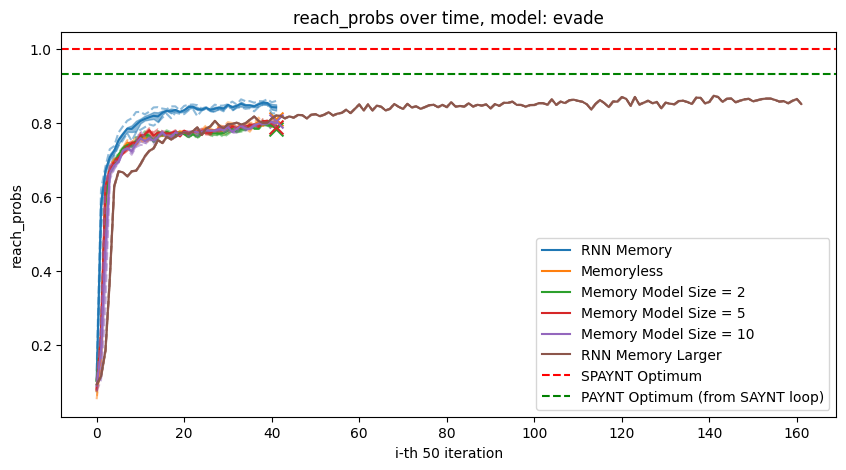

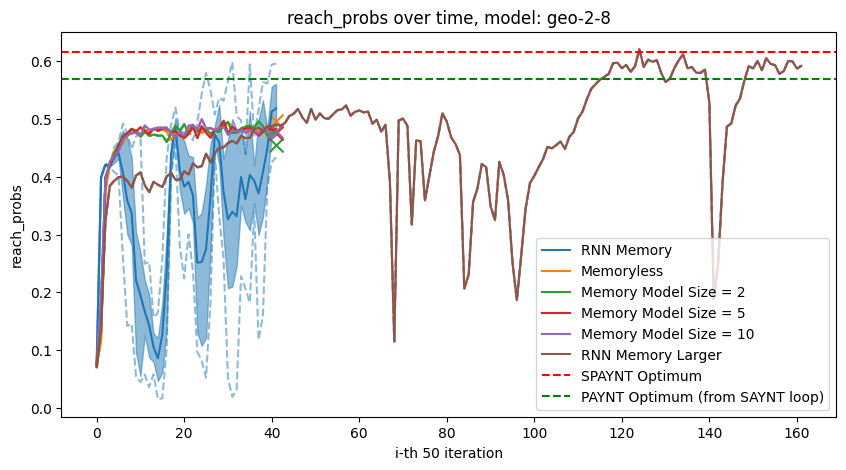

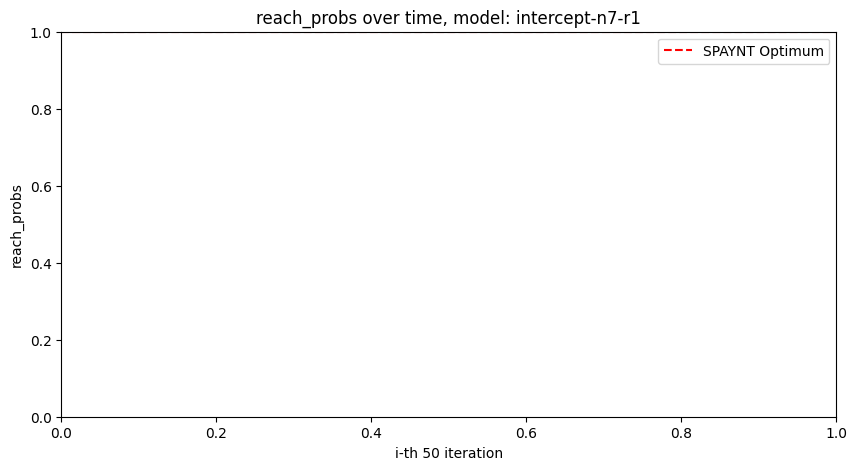

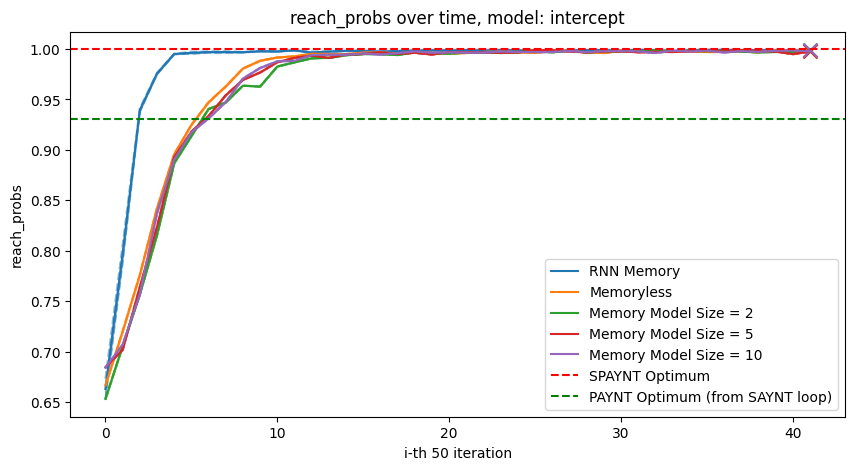

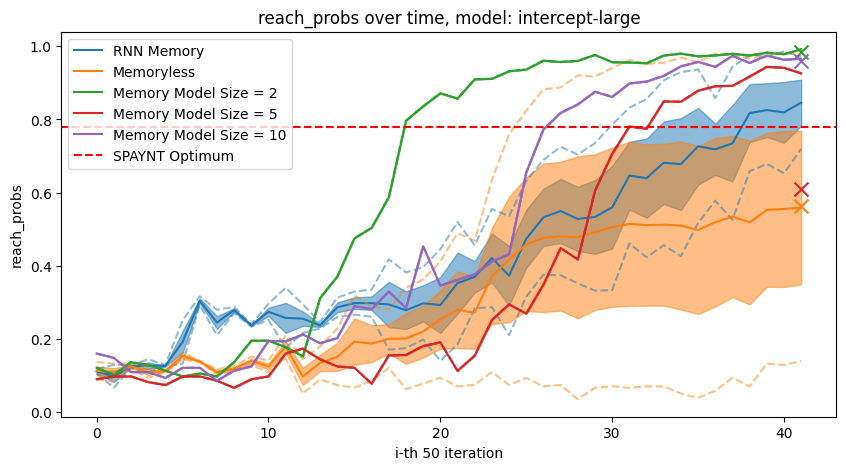

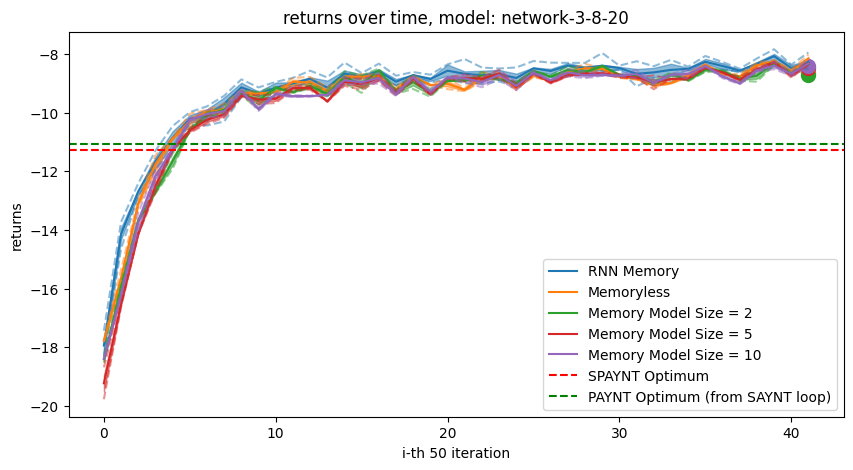

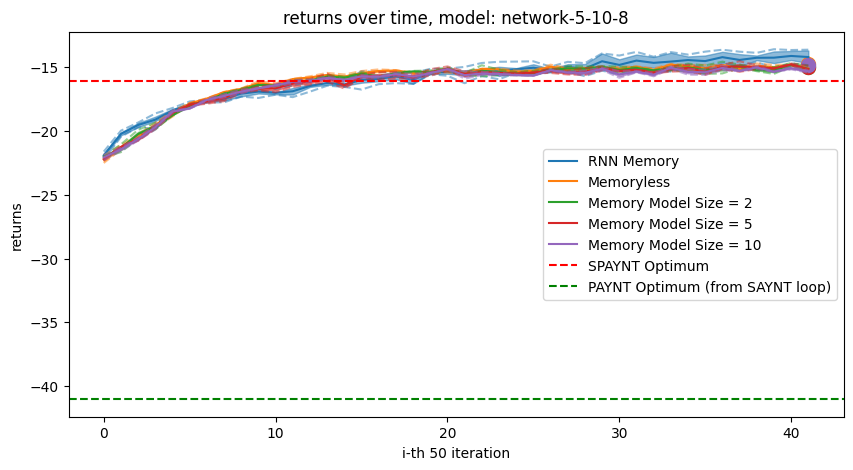

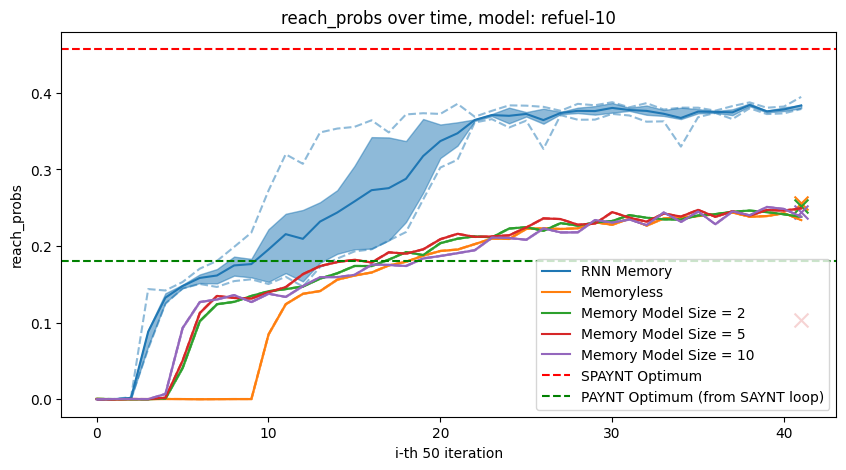

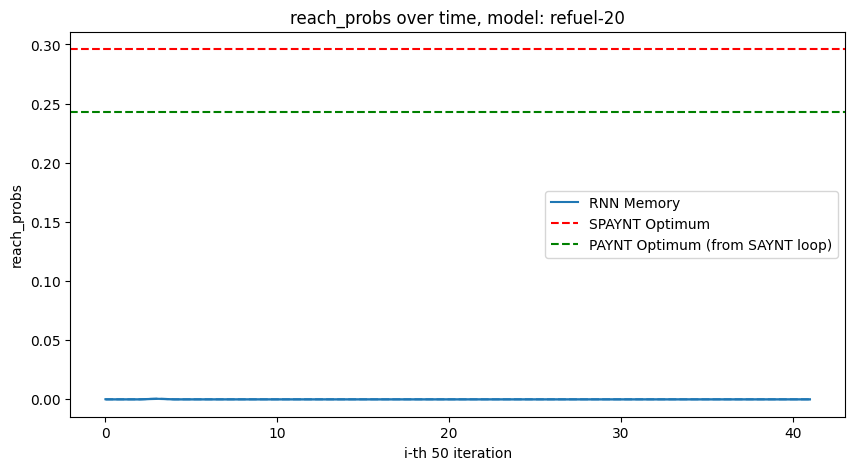

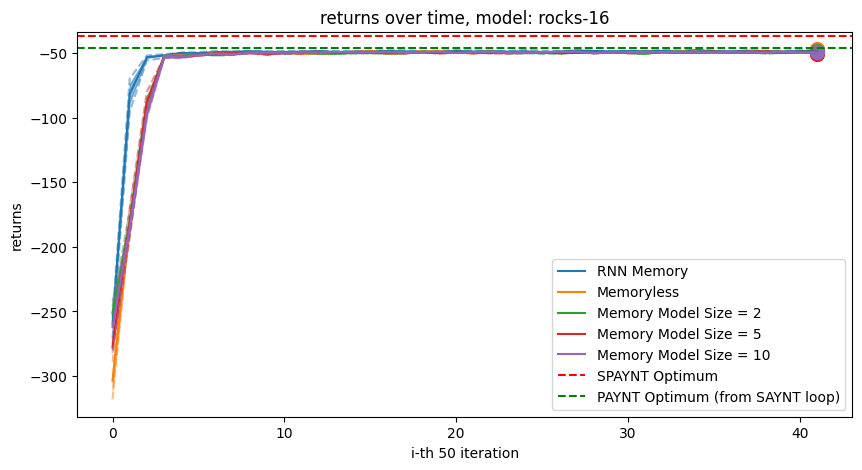

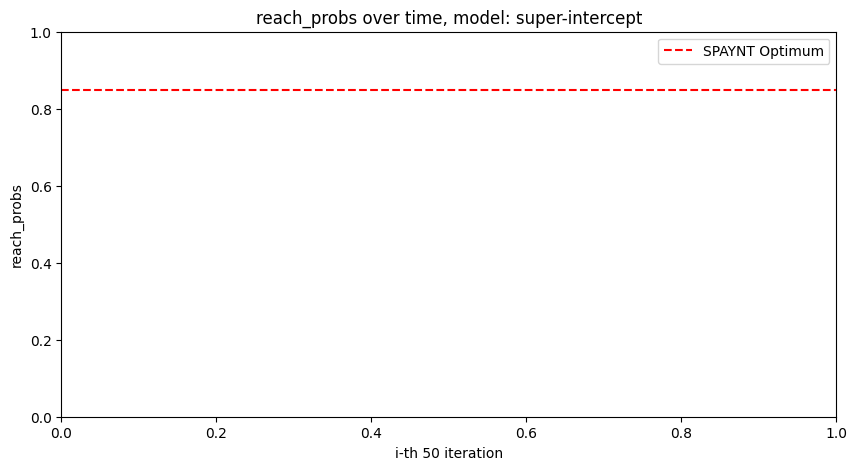

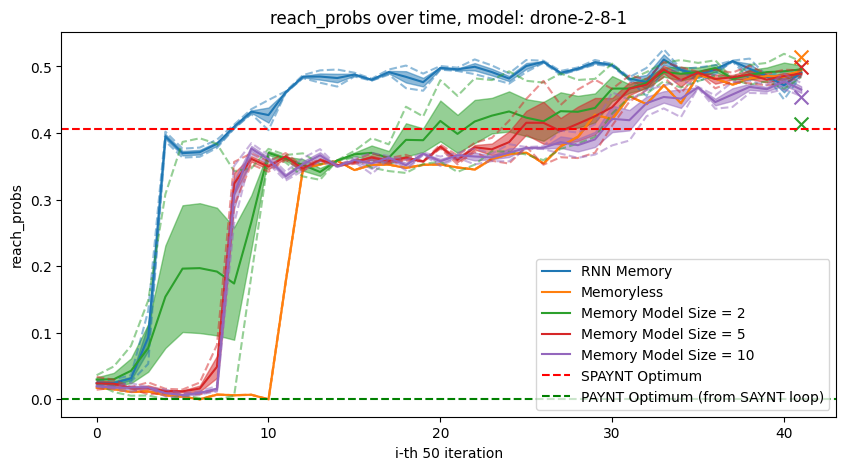

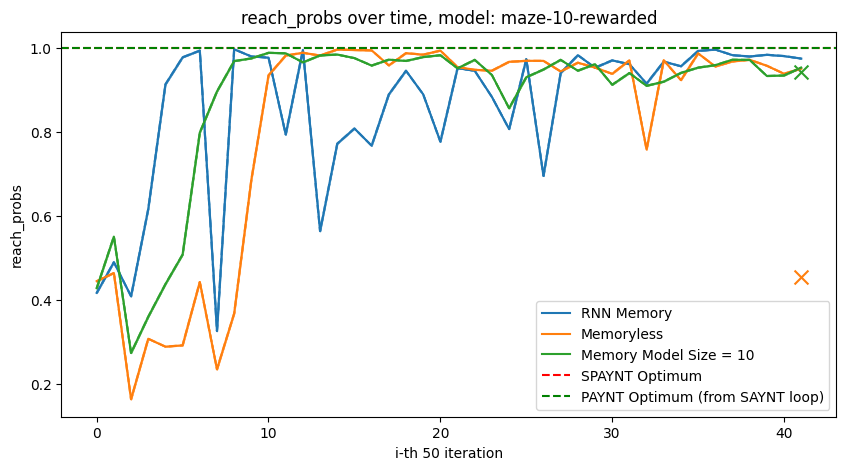

In [61]:
map_model_metric = {
    "evade" : "reach_probs",
    "geo-2-8" : "reach_probs",
    "intercept-n7-r1": "reach_probs",
    "intercept": "reach_probs",
    "intercept-large": "reach_probs",
    "network-3-8-20": "returns",
    "network-5-10-8": "returns",
    "refuel-10": "reach_probs",
    "refuel-20": "reach_probs",
    "rocks-16": "returns",
    "super-intercept": "reach_probs",
    "drone-2-8-1": "reach_probs",
    "maze-10-rewarded": "reach_probs",
}

for model_name in map_model_metric:
    plot_results_for_single_model(merged_results, model_name, map_model_metric[model_name], save_fig=True, save_path=f"experiments_plots/{model_name}_{map_model_metric[model_name]}.png")

{0: (array([2598,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


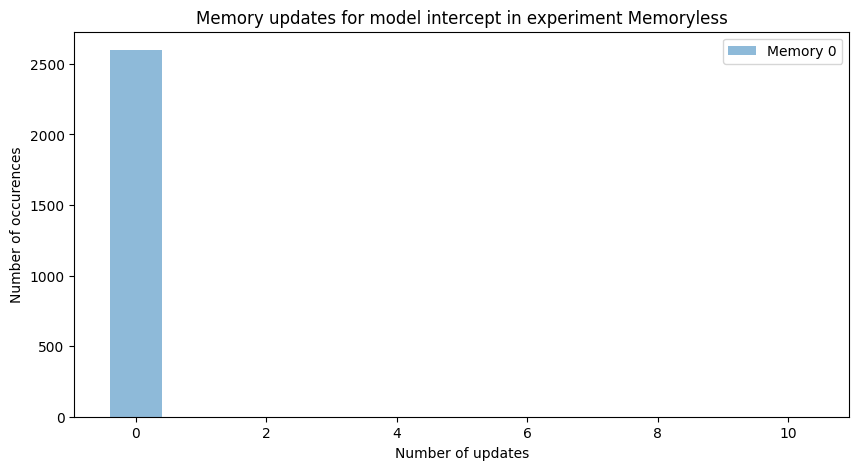

{0: (array([22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


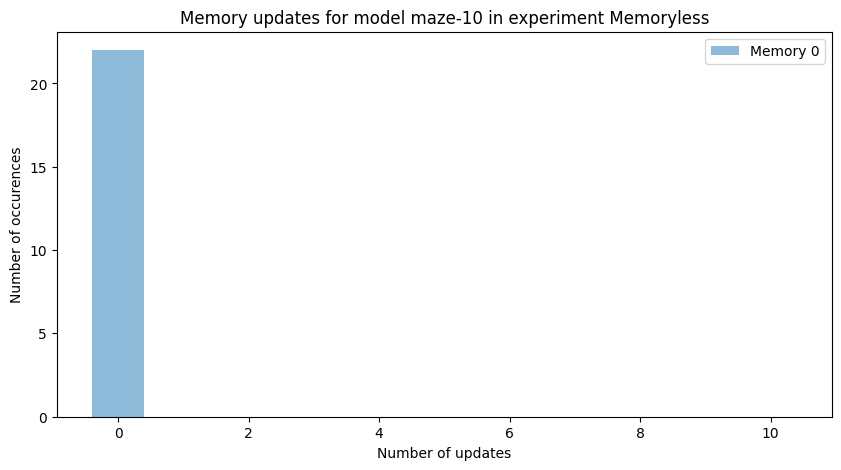

{0: (array([7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


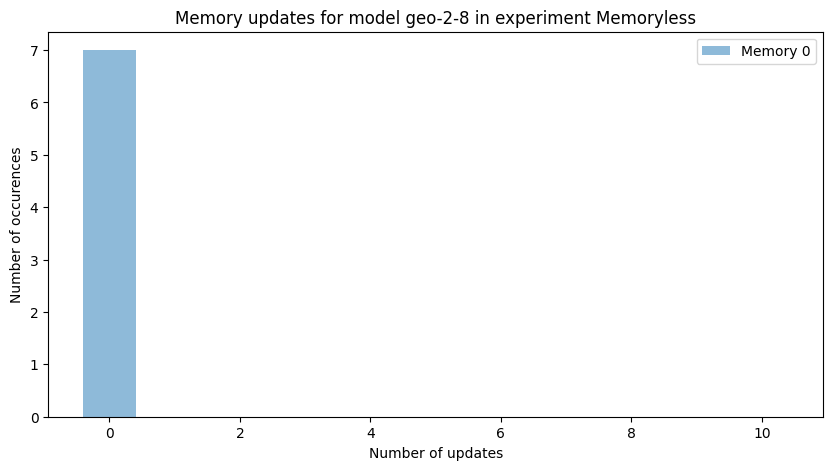

{0: (array([8344,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


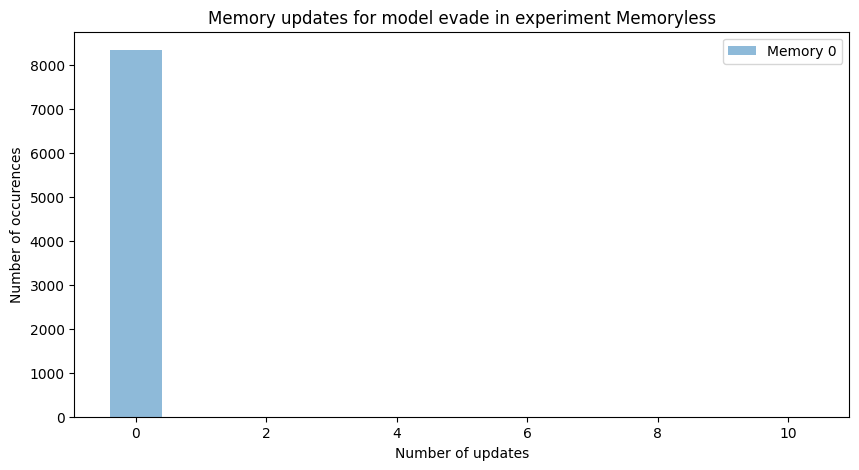

{0: (array([97938,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


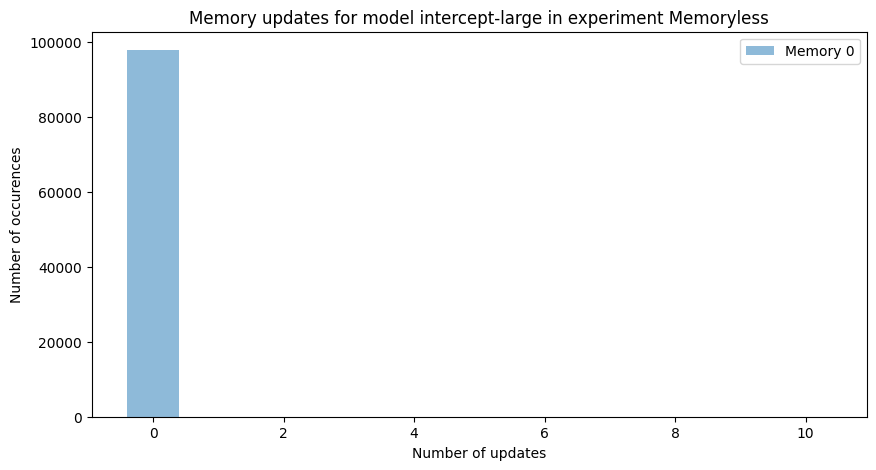

{0: (array([4410,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


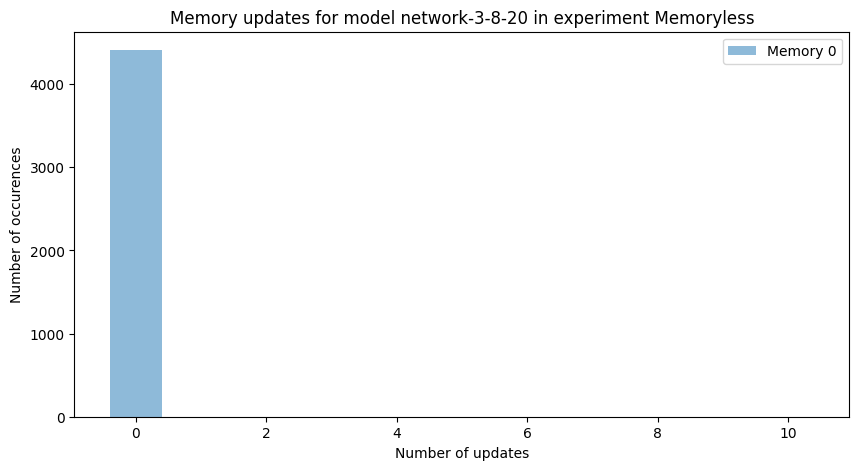

{0: (array([5522,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


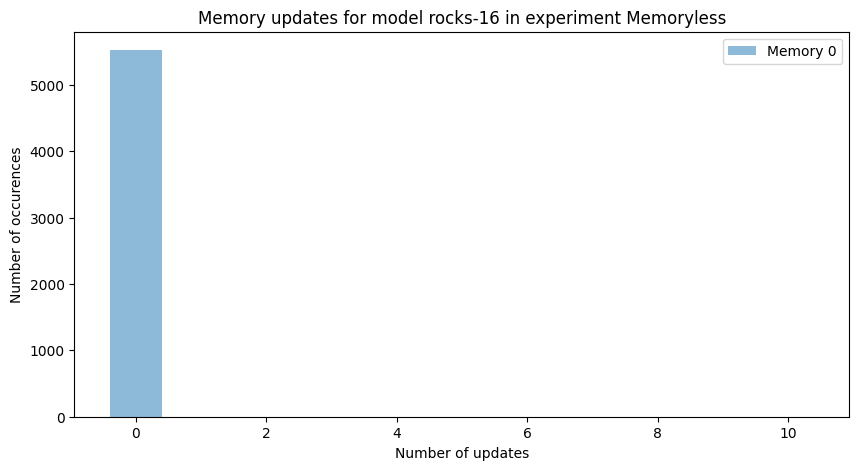

{0: (array([7472,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


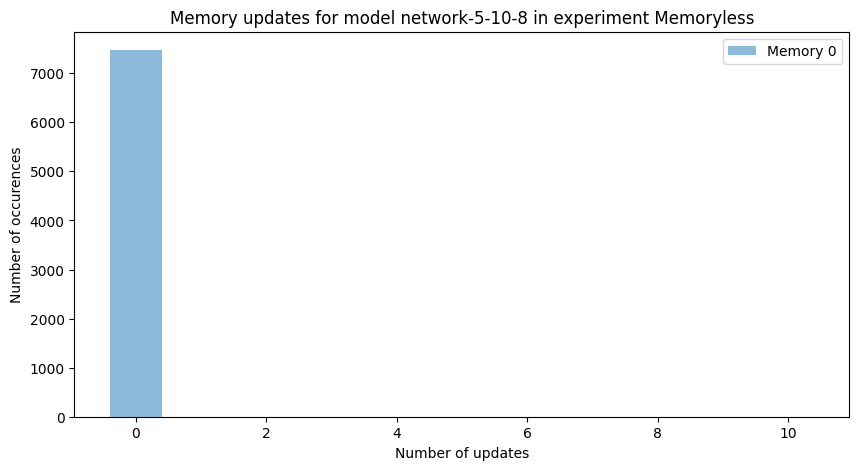

{0: (array([84,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


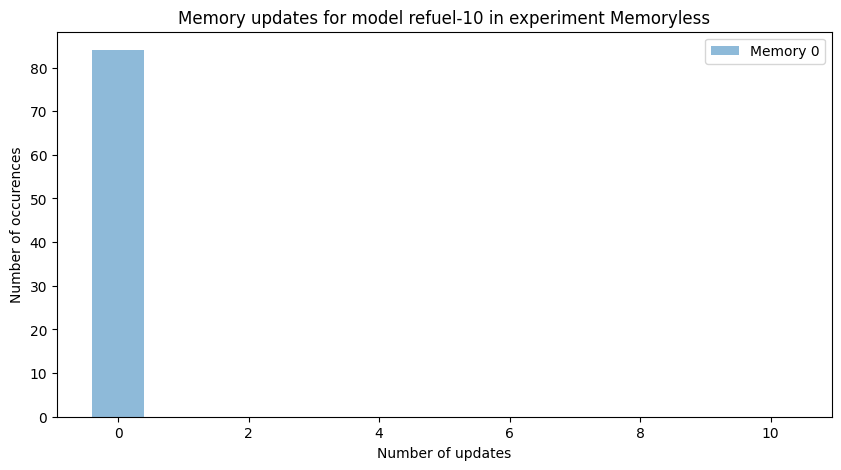

{0: (array([889,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


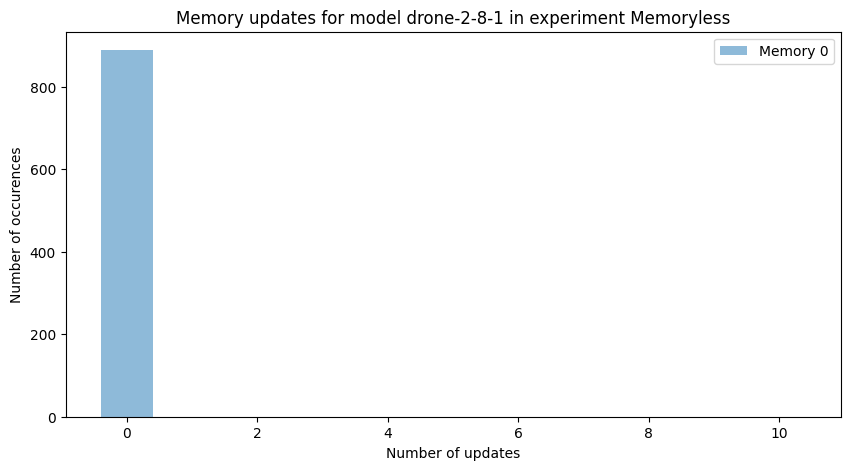

{0: (array([1180, 1418,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1156, 1442,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([1180, 1418,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1156, 1442,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


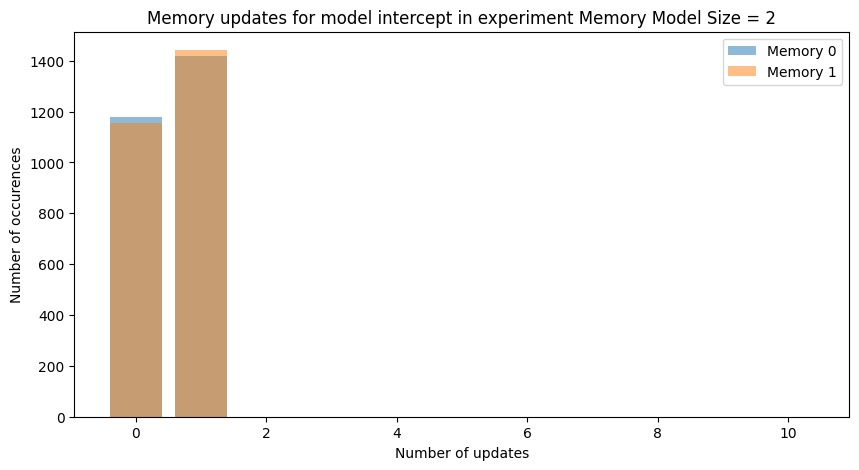

{0: (array([5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


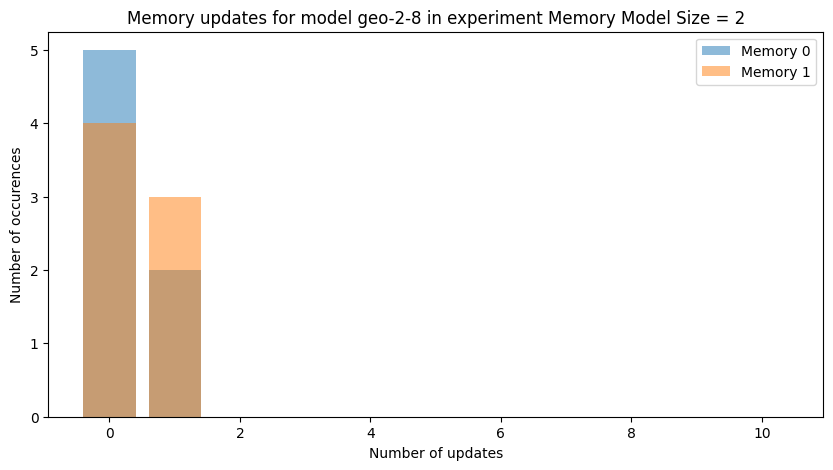

{0: (array([4099, 4245,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([4126, 4218,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([4099, 4245,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([4126, 4218,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


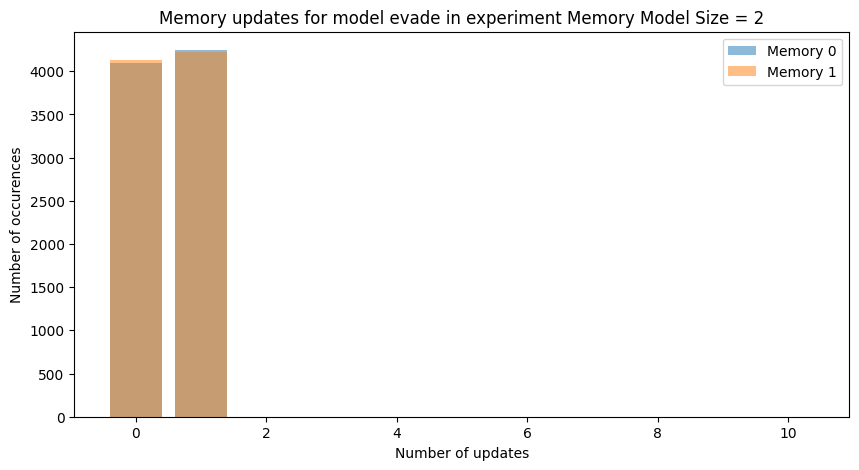

{0: (array([25371, 23598,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([25066, 23903,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([25371, 23598,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([25066, 23903,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


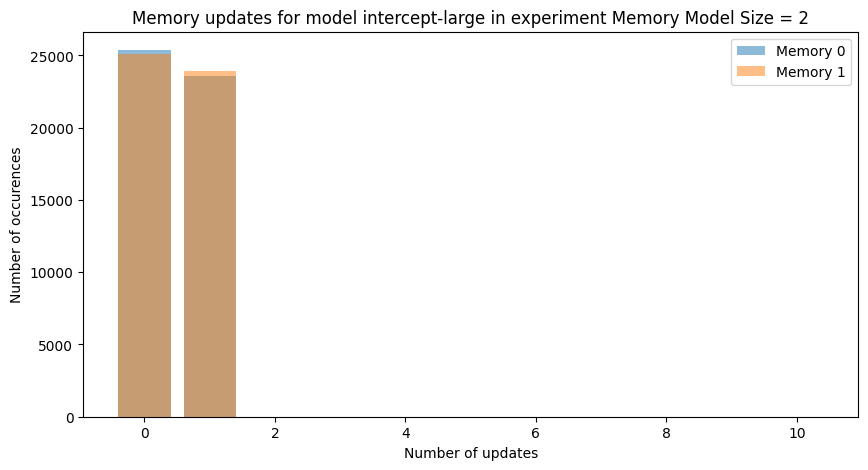

{0: (array([2176, 2234,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([2148, 2262,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([2176, 2234,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([2148, 2262,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


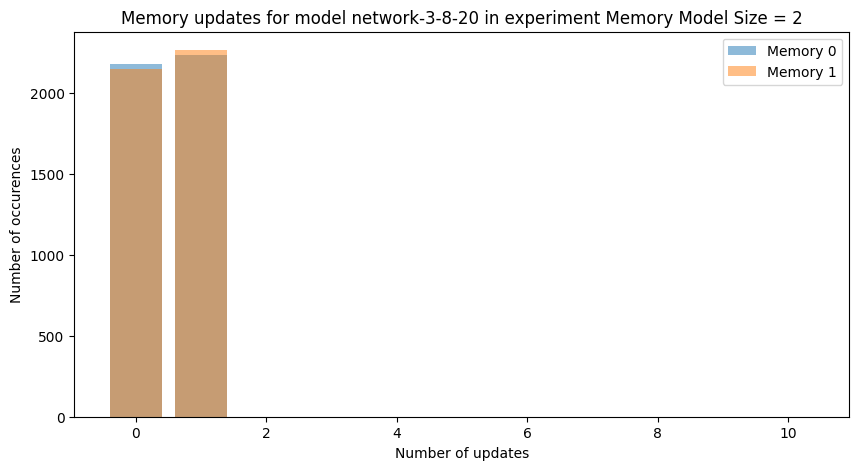

{0: (array([2868, 2654,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([2926, 2596,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([2868, 2654,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([2926, 2596,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


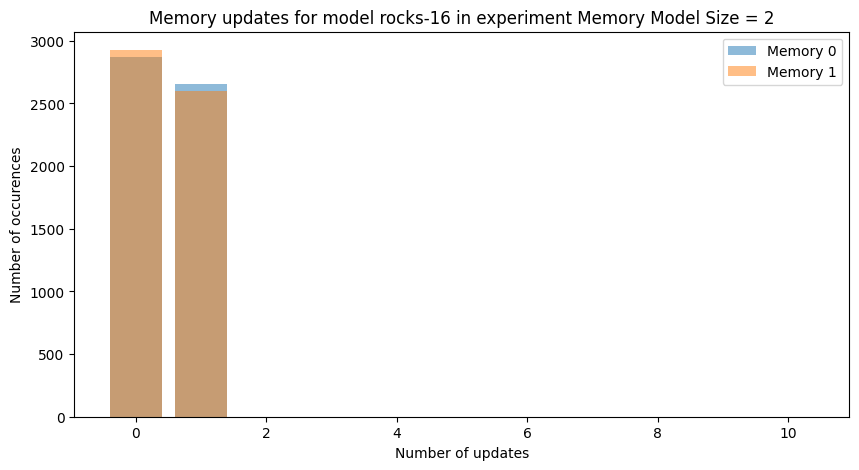

{0: (array([3657, 3815,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([3721, 3751,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([3657, 3815,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([3721, 3751,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


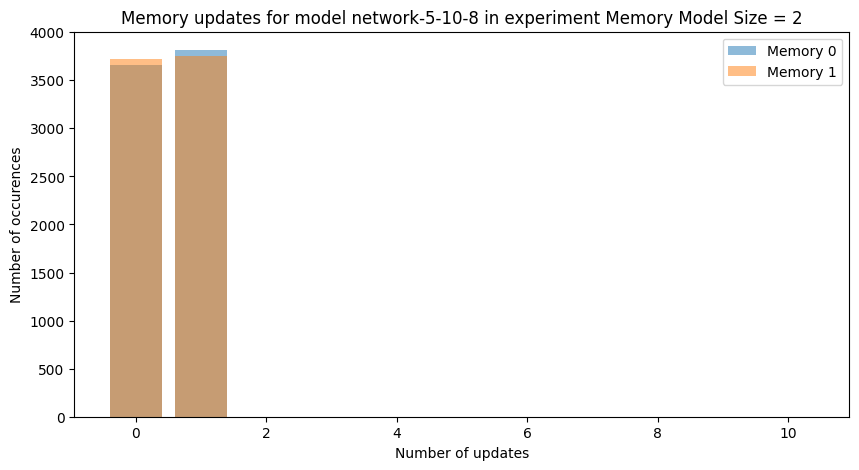

{0: (array([43, 41,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([49, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([43, 41,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([49, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


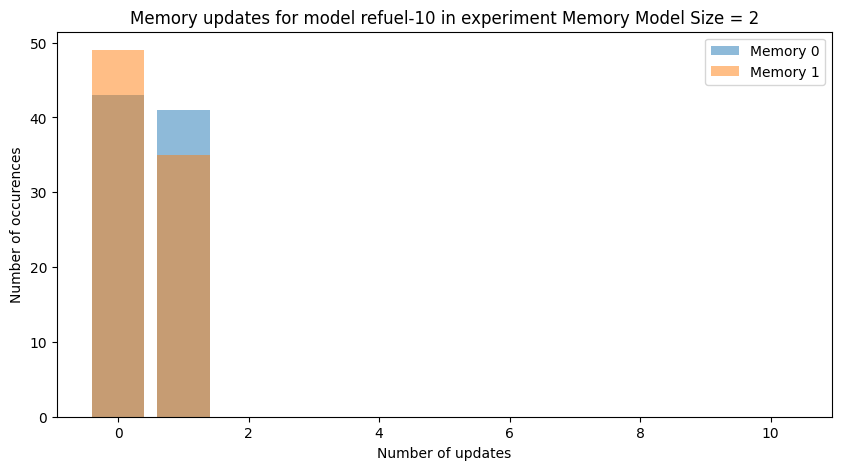

{0: (array([849, 929,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([794, 984,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([849, 929,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([794, 984,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}


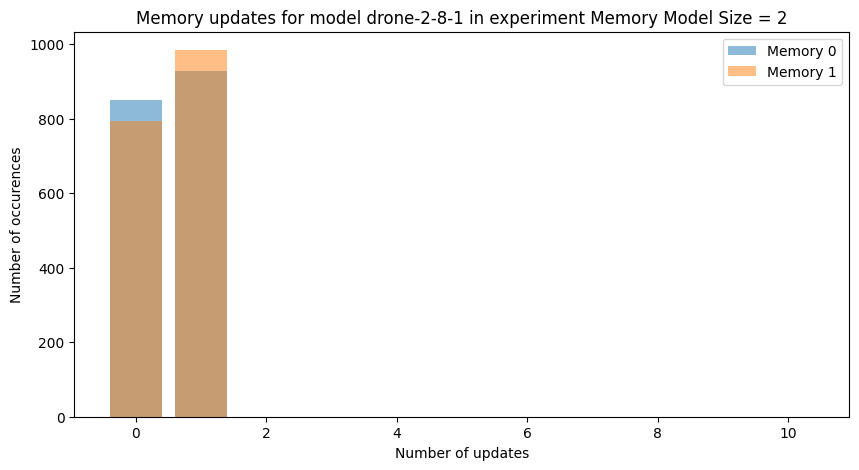

{0: (array([578, 453, 505, 489, 573,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([591, 473, 494, 471, 569,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([580, 440, 461, 551, 566,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([577, 448, 510, 491, 572,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([596, 476, 485, 458, 583,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([578, 453, 505, 489, 573,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([591, 473, 494, 471, 569,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([580, 440, 461, 551, 566,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1

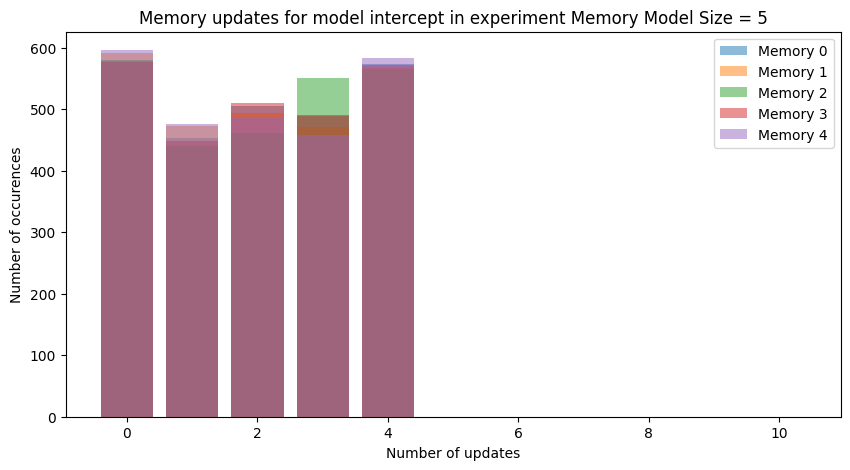

{0: (array([1, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([0, 3, 1, 2, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([0, 1, 2, 3, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([1, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([0, 3, 1, 2, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([0, 1, 2, 3, 1, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  

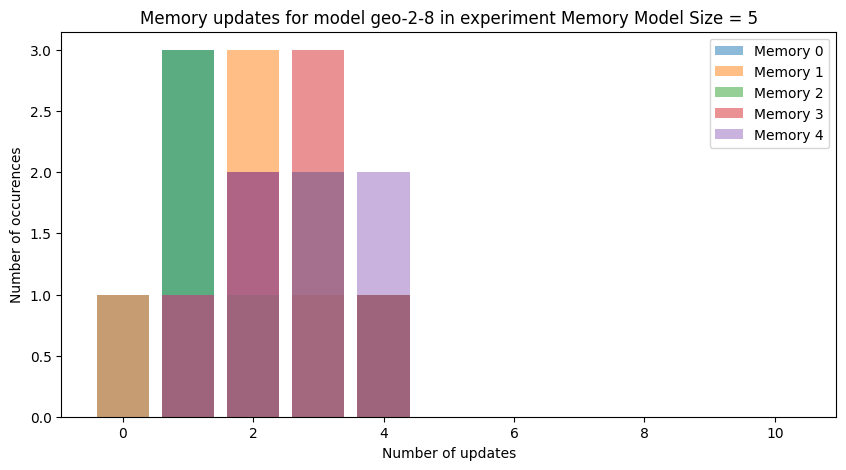

{0: (array([1836, 1686, 1559, 1552, 1711,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1809, 1629, 1556, 1607, 1743,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([1782, 1656, 1562, 1593, 1751,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([1766, 1614, 1571, 1644, 1749,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([1733, 1705, 1564, 1714, 1628,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([1836, 1686, 1559, 1552, 1711,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1809, 1629, 1556, 1607, 1743,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([1782, 1656, 1562, 1593, 1751

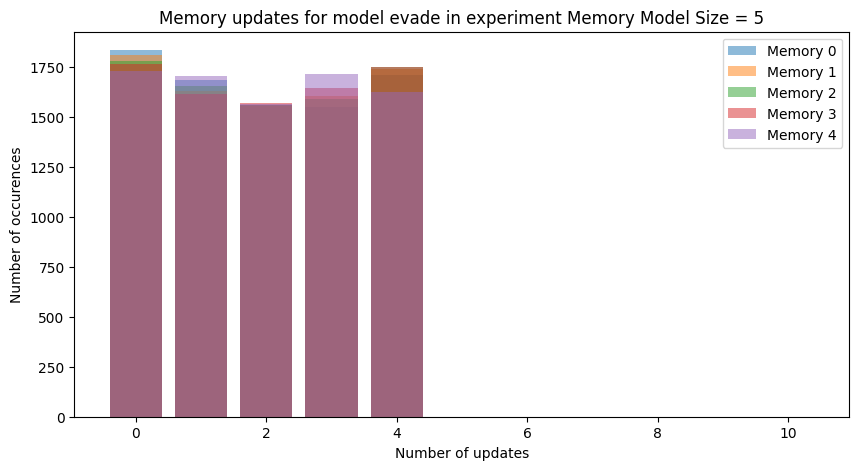

{0: (array([ 8822,  8923,  8711, 10851, 11662,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([ 8577,  8790,  8794, 10888, 11920,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([ 8512,  9004,  8717, 10966, 11770,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([ 8551,  8727,  8729, 11120, 11842,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([ 8559,  8843,  8646, 11052, 11869,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([ 8822,  8923,  8711, 10851, 11662,     0,     0,     0,     0,
           0,     0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([ 8577,  8790,  8794, 10888, 11920,     0,     0,     0,  

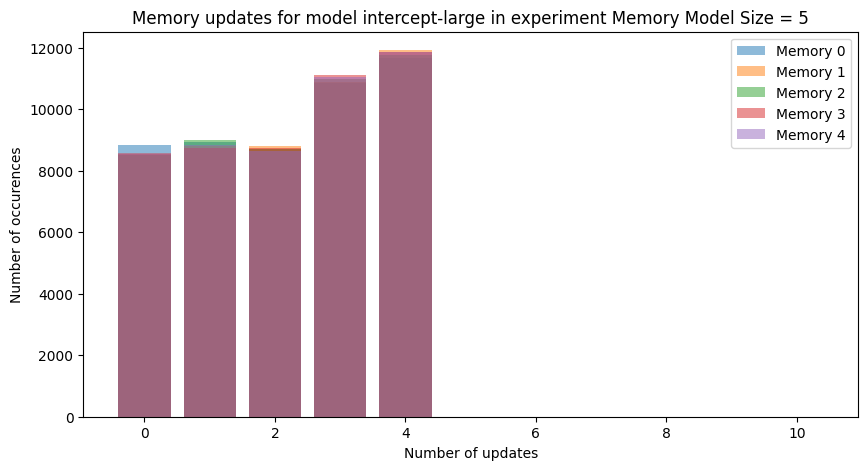

{0: (array([832, 852, 944, 898, 884,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([814, 856, 957, 927, 856,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([870, 853, 907, 921, 859,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([830, 870, 929, 925, 856,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([807, 911, 948, 872, 872,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([832, 852, 944, 898, 884,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([814, 856, 957, 927, 856,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([870, 853, 907, 921, 859,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1

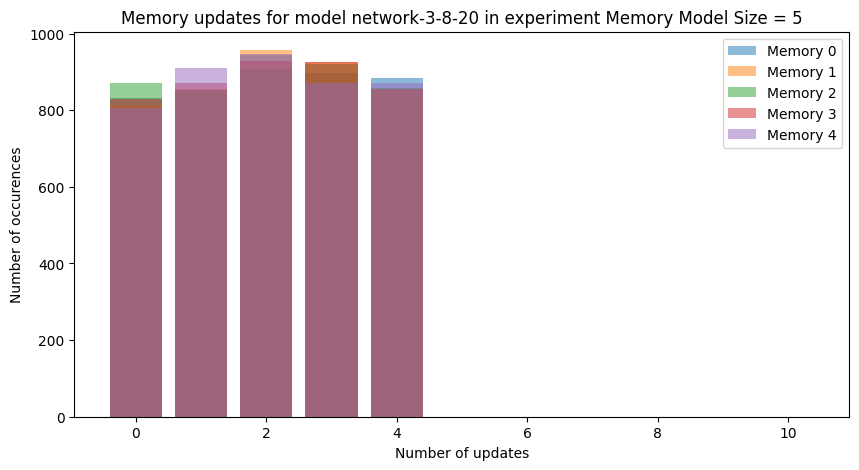

{0: (array([1112,  951, 1081, 1179, 1199,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1098, 1016, 1105, 1111, 1192,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([1058, 1040, 1100, 1166, 1158,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([1114, 1010, 1122, 1092, 1184,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([1138,  994, 1077, 1098, 1215,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([1112,  951, 1081, 1179, 1199,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1098, 1016, 1105, 1111, 1192,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([1058, 1040, 1100, 1166, 1158

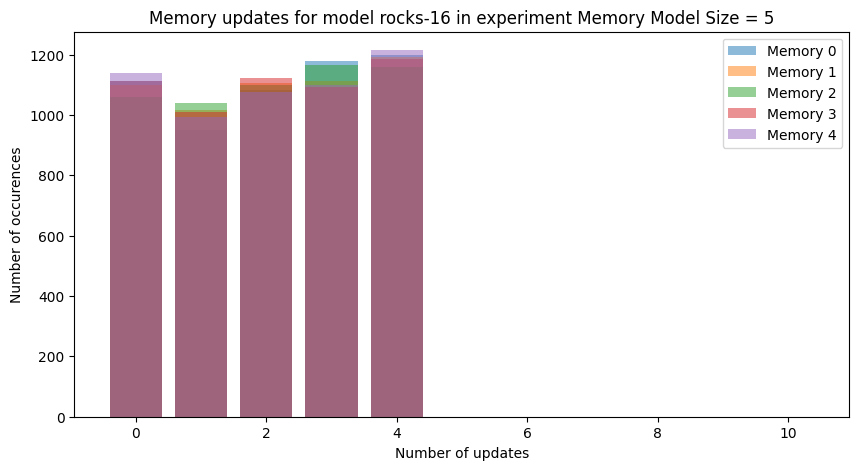

{0: (array([1451, 1590, 1463, 1551, 1417,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1484, 1519, 1407, 1604, 1458,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([1435, 1611, 1441, 1644, 1341,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([1402, 1583, 1495, 1624, 1368,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([1477, 1562, 1498, 1602, 1333,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([1451, 1590, 1463, 1551, 1417,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([1484, 1519, 1407, 1604, 1458,    0,    0,    0,    0,    0,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([1435, 1611, 1441, 1644, 1341

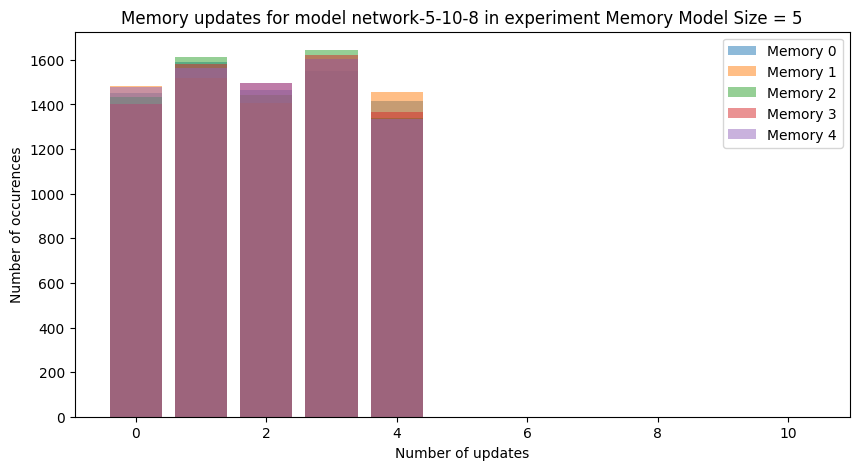

{0: (array([16, 16, 20, 12, 20,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([11, 20, 12, 19, 22,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([21, 17, 15, 16, 15,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([19, 12, 21, 17, 15,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([19, 18,  9, 16, 22,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([16, 16, 20, 12, 20,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([11, 20, 12, 19, 22,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([21, 17, 15, 16, 15,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([19, 12, 21, 17, 15,  0,  0,  0,  0,  0,  0]), array([ 0,  1,  2,  3

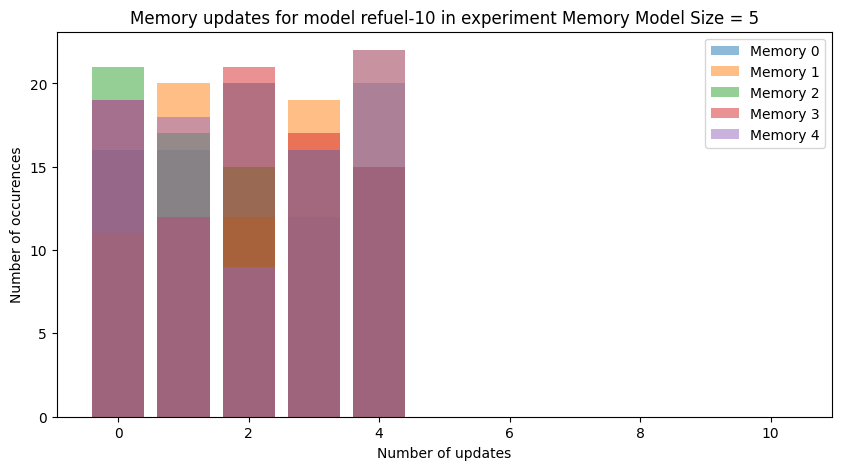

{0: (array([376, 346, 366, 328, 362,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([355, 329, 386, 337, 371,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([400, 315, 377, 327, 359,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([336, 342, 397, 323, 380,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([368, 331, 389, 338, 352,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))}
{0: (array([376, 346, 366, 328, 362,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([355, 329, 386, 337, 371,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([400, 315, 377, 327, 359,   0,   0,   0,   0,   0,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1

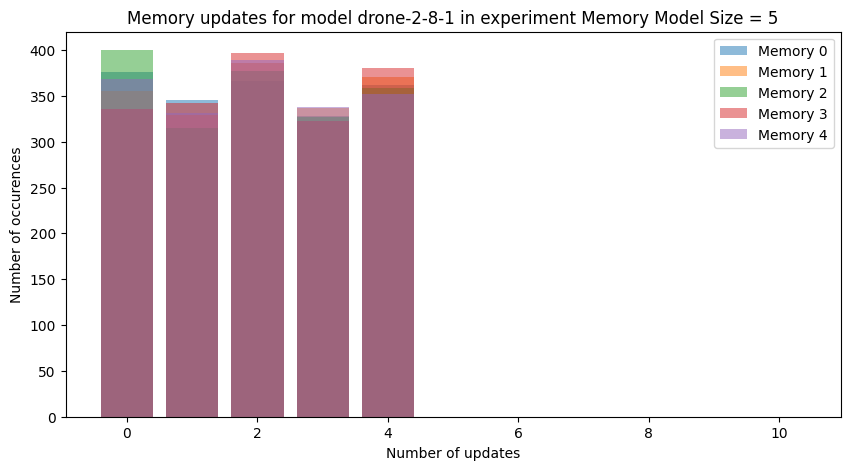

{0: (array([268, 231, 266, 233, 241, 246, 270, 247, 301, 295,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([255, 255, 249, 232, 274, 240, 254, 258, 279, 302,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([274, 280, 263, 211, 259, 232, 259, 257, 280, 283,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([285, 270, 248, 232, 265, 219, 247, 275, 278, 279,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([289, 253, 244, 243, 247, 248, 238, 257, 276, 303,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([245, 263, 274, 239, 291, 233, 242, 250, 268, 293,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([287, 260, 257, 236, 225, 247, 205, 274, 287, 320,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([262, 235, 232, 257, 257, 250, 256, 287, 267, 295,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10

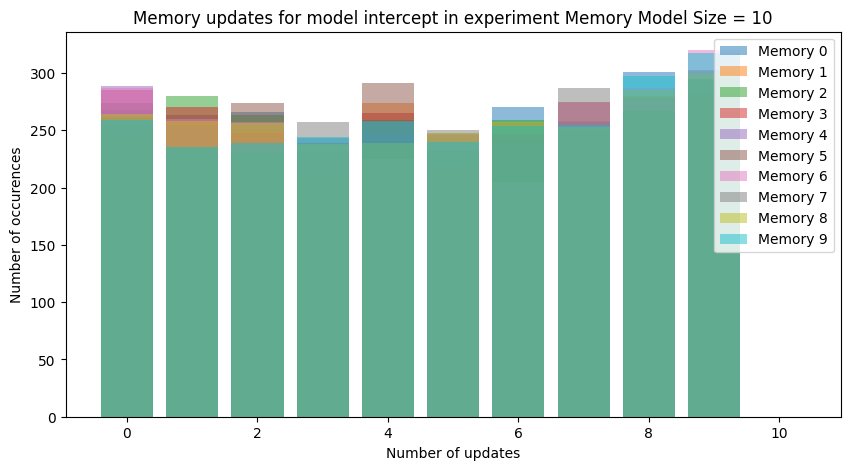

{0: (array([1, 3, 1, 1, 6, 1, 1, 3, 4, 1, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([2, 4, 0, 3, 0, 2, 2, 4, 3, 2, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([0, 1, 1, 3, 3, 0, 3, 1, 5, 5, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([3, 0, 1, 1, 5, 4, 1, 3, 2, 2, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([3, 4, 3, 1, 3, 0, 1, 3, 2, 2, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([3, 2, 1, 4, 1, 3, 1, 2, 3, 2, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([2, 1, 0, 4, 1, 3, 2, 4, 3, 2, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([4, 0, 2, 3, 4, 3, 1, 3, 0, 2, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 8: (array([2, 3, 4, 1, 1, 0, 4, 2, 4, 1, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 9: (array([1, 2, 2, 3, 3, 1, 3, 4, 3, 0, 0]), array([ 0,  1,  2

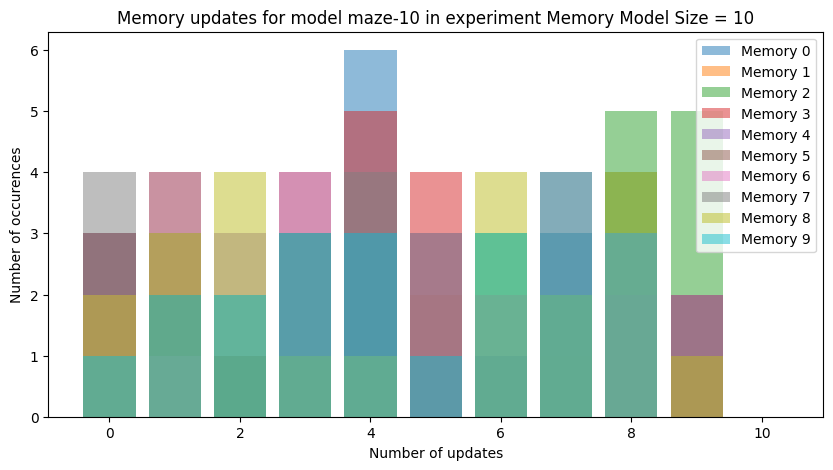

{0: (array([0, 1, 0, 0, 1, 0, 0, 0, 2, 3, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([0, 0, 1, 1, 0, 1, 0, 0, 3, 1, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([1, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([0, 0, 0, 2, 0, 2, 0, 0, 3, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([0, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 8: (array([1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 9: (array([0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0]), array([ 0,  1,  2

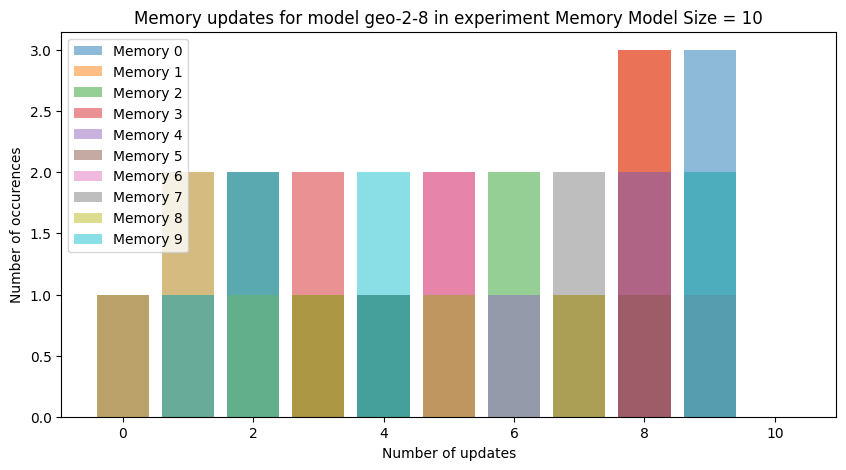

{0: (array([815, 759, 713, 872, 790, 870, 870, 823, 931, 901,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([816, 780, 793, 768, 817, 895, 888, 847, 867, 873,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([854, 798, 803, 798, 816, 853, 798, 848, 918, 858,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([770, 825, 774, 832, 772, 886, 884, 874, 905, 822,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([824, 776, 778, 793, 807, 896, 860, 857, 870, 883,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([808, 761, 769, 849, 826, 875, 829, 838, 923, 866,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([819, 776, 779, 802, 849, 831, 878, 887, 873, 850,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([811, 793, 756, 821, 779, 822, 889, 885, 912, 876,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10

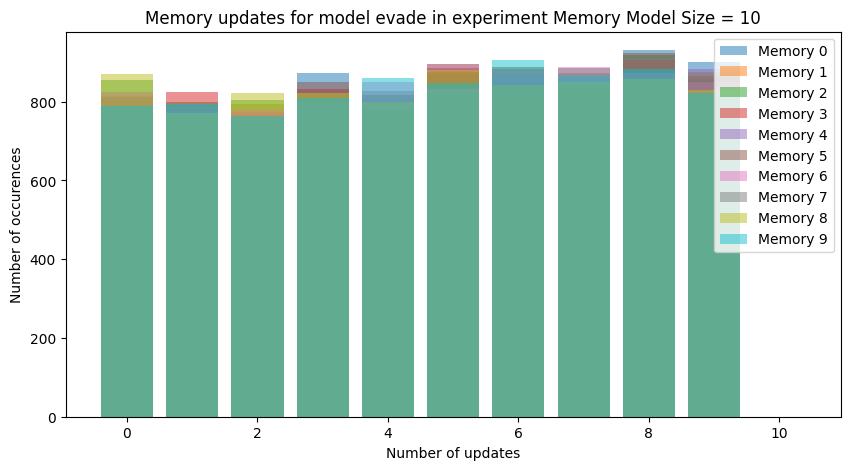

{0: (array([4689, 3705, 5571, 5505, 4832, 5050, 6513, 4023, 5254, 3827,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([4690, 3911, 5633, 5375, 4760, 5066, 6487, 3975, 5235, 3837,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([4647, 3759, 5641, 5392, 4951, 5018, 6657, 3881, 5276, 3747,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([4634, 3798, 5771, 5497, 4769, 5055, 6469, 4054, 5187, 3735,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([4772, 3822, 5591, 5452, 4816, 4943, 6586, 4060, 5128, 3799,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([4533, 3849, 5737, 5464, 4804, 5082, 6572, 4018, 5134, 3776,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([4513, 3807, 5526, 5643, 4858, 5059, 6627, 4090, 5106, 3740,    0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([4477, 3796, 5742, 5571, 4831,

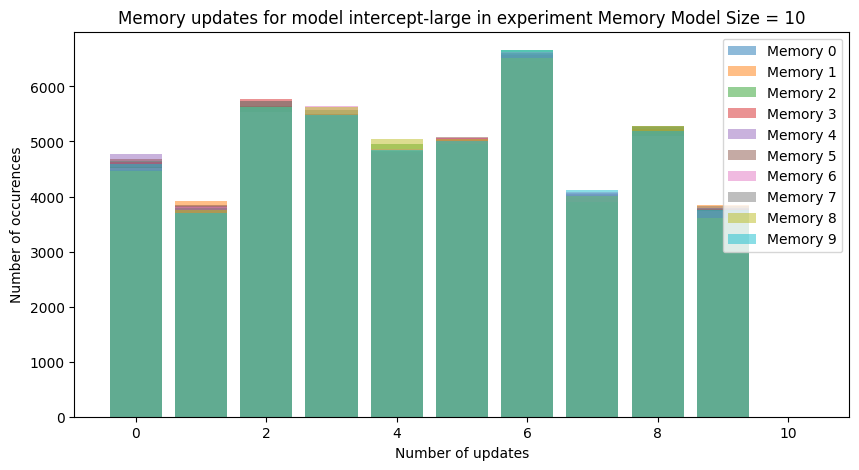

{0: (array([420, 419, 439, 451, 460, 454, 482, 412, 483, 390,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([429, 456, 430, 425, 445, 433, 493, 427, 445, 427,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([424, 416, 394, 449, 479, 470, 481, 448, 472, 377,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([426, 387, 398, 436, 467, 476, 508, 426, 478, 408,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([397, 431, 453, 416, 460, 475, 503, 403, 450, 422,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([390, 415, 402, 434, 459, 462, 500, 429, 477, 442,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([397, 445, 427, 431, 450, 463, 507, 440, 444, 406,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([417, 435, 402, 452, 452, 472, 453, 431, 460, 436,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10

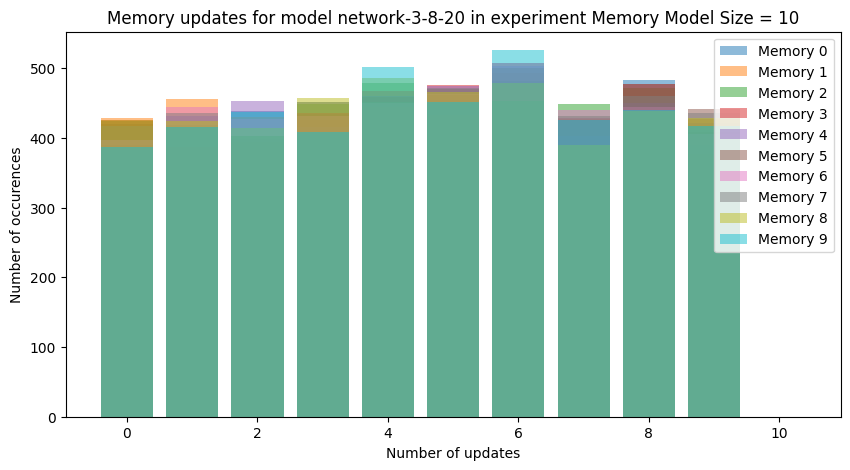

{0: (array([512, 607, 508, 535, 488, 506, 621, 589, 559, 597,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([554, 584, 512, 539, 471, 532, 648, 586, 559, 537,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([533, 590, 508, 536, 489, 527, 622, 572, 562, 583,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([556, 594, 523, 589, 524, 525, 599, 561, 519, 532,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([559, 575, 493, 570, 483, 544, 649, 569, 509, 571,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([553, 621, 469, 568, 521, 533, 587, 593, 506, 571,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([566, 568, 541, 555, 479, 498, 629, 576, 526, 584,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([555, 603, 516, 576, 505, 517, 609, 561, 478, 602,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10

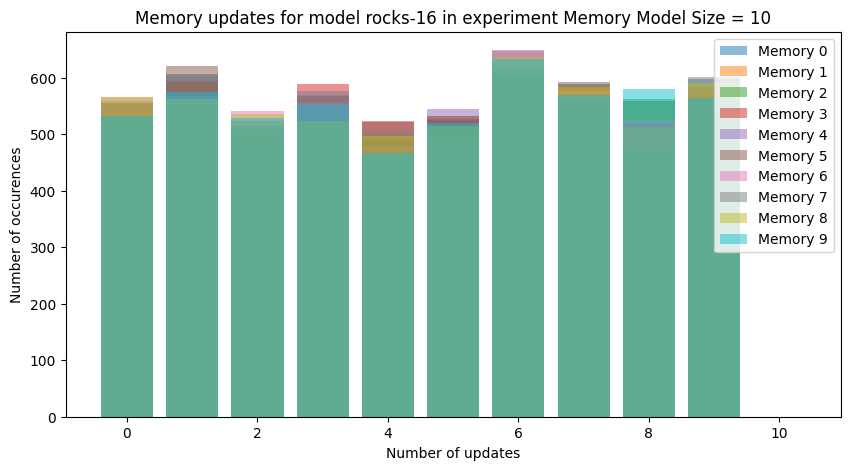

{0: (array([686, 714, 728, 783, 765, 870, 734, 761, 688, 743,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([655, 725, 706, 827, 748, 801, 758, 758, 677, 817,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([633, 739, 708, 816, 766, 820, 766, 771, 729, 724,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([702, 722, 743, 757, 747, 813, 743, 782, 696, 767,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([691, 749, 727, 783, 775, 812, 776, 755, 668, 736,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([679, 731, 777, 796, 745, 817, 764, 770, 633, 760,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([673, 725, 792, 768, 753, 812, 773, 708, 689, 779,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([647, 725, 751, 739, 759, 831, 797, 766, 676, 781,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10

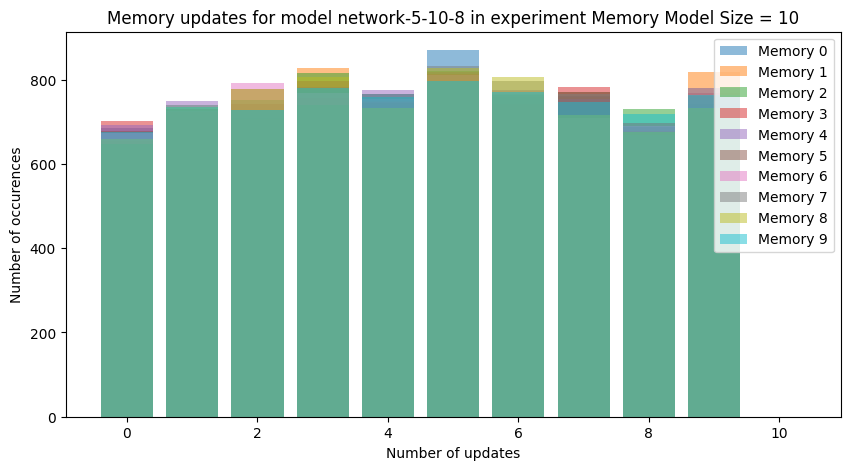

{0: (array([11,  6,  6, 12,  6,  6,  8,  6, 12, 11,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([ 9,  8,  8, 11,  7, 10,  5, 10, 11,  5,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([10, 12,  9,  7,  7,  8, 10,  7,  8,  6,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([ 5, 10,  9,  3, 14,  8, 11,  8,  9,  7,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([ 7,  4,  9,  6,  7,  7, 16,  6, 13,  9,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([ 4,  8,  7,  6,  6, 11, 11,  9, 15,  7,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([10,  7, 10,  5,  6,  7,  7,  7, 14, 11,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([ 6,  8,  7,  9, 11, 10,  7, 13,  4,  9,  0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 8: (array([ 8,  8,  5, 11,  9, 12,  8,  8,  6,  9,  0]), array([ 0,  1,  2,  3,

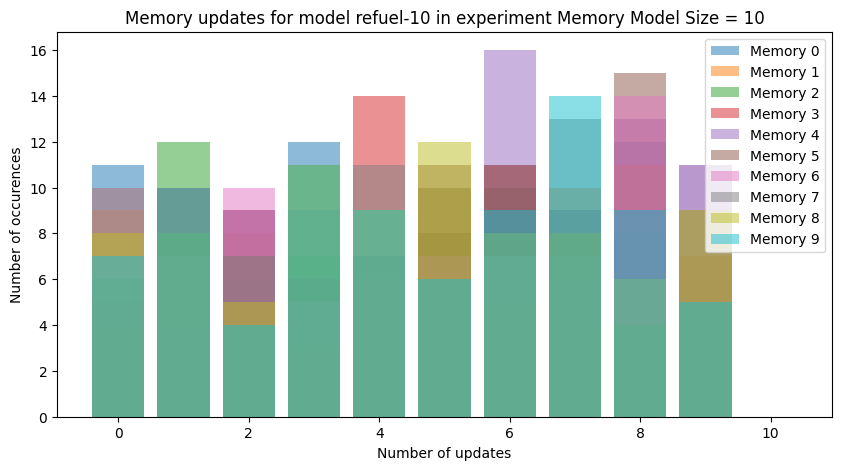

{0: (array([167, 196, 210, 171, 178, 191, 167, 171, 188, 139,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 1: (array([174, 195, 170, 157, 192, 211, 186, 164, 178, 151,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 2: (array([182, 168, 173, 168, 195, 170, 215, 169, 184, 154,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 3: (array([203, 199, 153, 153, 186, 190, 183, 162, 189, 160,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 4: (array([170, 183, 161, 170, 199, 199, 192, 153, 206, 145,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 5: (array([152, 188, 155, 174, 192, 204, 204, 162, 195, 152,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 6: (array([158, 185, 156, 170, 189, 216, 190, 160, 186, 168,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])), 7: (array([180, 180, 184, 178, 195, 179, 211, 159, 166, 146,   0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10

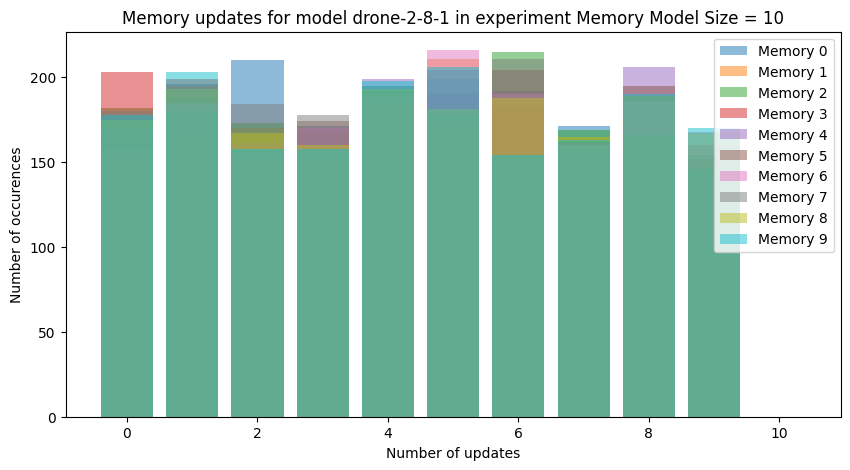

In [62]:
# merged_fscs

def compute_per_memory_histogram(fscs_updates_for_model):
    """Computes histogram of updates for each memory from matrix of shape (x, y, z), where each y represents one memory, x each fsc and z updates given fsc x and memory y. 
    The histogram is computed for each memory from y."""
    per_memory_histograms = {}
    for memory in range(fscs_updates_for_model.shape[1]):
        per_memory_histograms[memory] = np.histogram(fscs_updates_for_model[:, memory, :], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    return per_memory_histograms

pdfs = {}
for experiment_name in merged_fscs:
    observation_to_update_tables = {}
    percentages_of_miss = {}
    for model_name in merged_fscs[experiment_name]:
        # print(f"Model {model_name} in experiment {experiment_name}")
        # print(merged_fscs[experiment_name][model_name]["percentage_of_misses"])
        # print(merged_fscs[experiment_name][model_name]["observation_to_action_table"])
        observation_to_update_table_hist = compute_per_memory_histogram(np.array(merged_fscs[experiment_name][model_name]["observation_to_update_table"]))
        observation_to_update_tables[model_name] = observation_to_update_table_hist
    pdfs[experiment_name] = pd.DataFrame(observation_to_update_tables, columns=observation_to_update_tables.keys())

    # plot results
    for model_name in observation_to_update_tables:
        plt.figure(figsize=(10, 5))
        for memory in observation_to_update_tables[model_name]:
            print(observation_to_update_tables[model_name])
            plt.bar(np.arange(len(observation_to_update_tables[model_name][memory][0])), observation_to_update_tables[model_name][memory][0], alpha=0.5, label=f"Memory {memory}")
        plt.title(f"Memory updates for model {model_name} in experiment {experiment_name}")
        plt.xlabel("Number of updates")
        plt.ylabel("Number of occurences")
        plt.legend()
        plt.show()
        plt.close()
    